# Lid-driven Cavity Flow using the Projection Method

## Introduction 

Consider the 2D incompressible Navier-Stokes equations (also known as momentum equations)

\begin{align}
& \frac{\partial u}{\partial t}+u \cdot \frac{\partial u}{\partial x}+v \cdot \frac{\partial u}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial x}+\nu \frac{\partial^2 u}{\partial x^2}+\nu \frac{\partial^2 u}{\partial y^2}, \\
& \frac{\partial v}{\partial t}+u \cdot \frac{\partial v}{\partial x}+v \cdot \frac{\partial v}{\partial y}=-\frac{1}{\rho} \frac{\partial p}{\partial y}+\nu \frac{\partial^2 v}{\partial x^2}+\nu \frac{\partial^2 v}{\partial y^2},
\end{align}

and the continuity equation

\begin{equation}
\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}=0,
\end{equation}

where $\mathbf{u} = (u,v)$ are flow velocities  in $x,y$ direction, $\rho$ is the density (constant for incompressible flow), $\nu$ is the kinematic viscosity, and $p$ stands for pressure.
One can write them into a more compact form (dimension free) as 

\begin{align}
\frac{\partial \mathbf{u}}{\partial t}+(\mathbf{u} \cdot \nabla) \mathbf{u}&= -\frac{1}{\rho} \nabla p+\nu \nabla^2 \mathbf{u}, \\
\nabla \cdot \mathbf{u} & =0.
\end{align}

---

### Staggered Grid

To deal with the checkerboard pressure problem, we assign different mesh systems to each primitive  variables $u,v,p$ as following.


<p align="center">
  <a href="https://www.cfd-online.com/Wiki/Staggered_grid">
    <img width=50% src="./Gallery/staggered_grid.png">
  </a>
</p>

The pressure is stored at the cell center and the velocities are stored at the cell faces.

---

### Chorin's Projection Method

The algorithm adopts an operator splitting approach in which one considers the viscous forces (in the first half step) and the pressure forces (in the second half step) separately. A distinguishing feature of Chorin's projection method is that the velocity field is forced to satisfy a discrete continuity constraint at the end of each time step.

We first discretize the time domain using an explicit Euler scheme

\begin{equation}
\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}=-\frac{1}{\rho} \nabla p^{n+1}-\left(\mathbf{u}^n \cdot \nabla\right) +\nu \nabla^2 \mathbf{u}^n,
\end{equation}

where the time-step $\Delta t$ should be chosen so that $u \Delta t / \Delta x<1$ to satisfy the Courant-Friedrichs-Lewy (CFL) condition.

**Step I: Predictor step** \
Computes an intermediate velocity ${\mathbf  {u}}^{*}$, explicitly using the momentum equation by ignoring the pressure gradient term $\nabla p^{n+1} = 0$:

\begin{align}
\frac{\mathbf{u}^*-\mathbf{u}^n}{\Delta t} = -\left(\mathbf{u}^n \cdot \nabla\right) \mathbf{u}^n+\nu \nabla^2 \mathbf{u}^n, 
\end{align}

where $\mathbf{u}^n$ is the velocity at $n^{\text {th }}$ time step. 

**Step II: Projection step** \
We correct the intermediate velocity to obtain the final solution of the time step $\mathbf{u}^{n+1}$ 

\begin{equation}
\frac{\mathbf{u}^{n+1}-\mathbf{u}^*}{\Delta t}=-\frac{1}{\rho} \nabla p^{n+1}.
\end{equation}

**Step III: Pressure Poisson equation** \
Considering the divergence (continuity) condition at the next time step $t=n+1$, we have

\begin{align}
\nabla \cdot \mathbf{u}^{n+1} = 0
\quad \Rightarrow \quad
\nabla \cdot \bigg(\mathbf{u}^*-\frac{\Delta t}{\rho} \nabla p^{n+1} \bigg) = 0.
\end{align}

Reorganize it to obtain a Poisson problem

\begin{align}
\boxed{\nabla^2 p^{n+1}=\frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*.}
\end{align}

**Step IV: Velocity correction** \
Once we solve the Poisson problem, we can correct the velocity from ${\mathbf  {u}}^{*}$ to the next time step $\mathbf{u}^{n+1}$ 
\begin{align}
\mathbf{u}^{n+1}=\mathbf{u}^*-\frac{\Delta t}{\rho} \nabla p^{n+1}.
\end{align}

---

## Algorithm

The code below follows this guide https://www.montana.edu/mowkes/research/source-codes/GuideToCFD.pdf


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import sparse
from qiskit.circuit.library import TwoLocal,RealAmplitudes,EfficientSU2,NLocal,PauliTwoDesign,QAOAAnsatz
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import CXGate, UGate
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.eigensolvers import NumPyEigensolver
from qiskit_aer.primitives import Estimator as Aer_Estimator
from qiskit_aer.primitives import Sampler as Aer_Sampler
from qiskit.primitives import Sampler as QSampler
from qiskit import Aer, transpile, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import *
import time
import dill as pickle
import sys
import pentapy as pp
from quantum_utils import *
from qiskit_ibm_runtime import Session, QiskitRuntimeService, Options
from qiskit_ibm_runtime import Estimator as Estimator_Runtime
from qiskit_ibm_runtime import Sampler as Sampler_Runtime
from vqls_prototype.tomography import HTreeQST, FullQST, ShadowQST
from qiskit_ibm_provider.ibm_provider import IBMProvider
from qiskit.quantum_info import state_fidelity
from qiskit_aer.noise import NoiseModel
from HTreeQST_from_sv import HTreeQST_from_sv

solver = 'sparse'
res_tol = 1e-4
size = 2
Lx = 1              # length of domian in x-direction
Ly = 1              # length of domian in y-direction
n = size             # Half the number of qubits
nx = 2**n            # grid size in x-direction. Fixed to be in terms of number of qubits
ny = 2**n            # grid size in y-direction. Fixed to be in terms of number of qubits and square
quantum = False
hardware = False
noise = False
full_qst = False
use_init_state = True
use_statevector = False
use_htree_on_exact_state = False #(currently broken)
shots = 50000
noise_factor = 0.001
q_method = "Global"
service = QiskitRuntimeService(name='ornl')
device = service.get_backend('ibm_algiers')

Re = 100          # Reynolds number
nu = 1/Re           # kinematic viscosity
rho = 1.0           # density
dt = 0.01        # time step size. 
itr = 50     # iterations
mark = 1
eig_tol = 0.7
rerun_its = 0
# Create staggered grid index system
imin, jmin = 1, 1
imax = imin + nx - 1
jmax = jmin + ny - 1

# Define ghost cells for boundary conditions
#x = np.zeros(jmax + 2)
x = sparse.lil_matrix((jmax+2,1))
#y = np.zeros(jmax + 2)
y = sparse.lil_matrix((jmax+2,1))
x[imin: imax + 2] = np.linspace(0, Lx, nx + 1, endpoint=True)
y[jmin: jmax + 2] = np.linspace(0, Ly, ny + 1, endpoint=True)

dx = (x[imin + 1] - x[imin]).data[0]
dy = (y[jmin + 1] - y[jmin]).data[0]
dxi = 1 / dx
dyi = 1 / dy

# Variable declaration
u = sparse.lil_matrix((imax + 2, jmax + 2))
v = sparse.lil_matrix((imax + 2, jmax + 2))
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    #std_vals.append(std['variance'])
def boundary_condition(u, v):
    u[imin, jmin - 1:jmax + 1] = 0
    u[imax + 1, jmin - 1:jmax + 1] = 0
    u[imin: imax + 2, jmin - 1] = -u[imin: imax + 2, jmin]
    u[imin: imax + 2, jmax + 1] = 2*np.ones((jmax+1,imax + 1-imax)) - u[imin: imax + 2, jmax]


    v[imin - 1: imax + 2, jmin] = 0
    v[imin - 1: imax + 2, jmax + 1] = 0
    v[imin - 1, jmin:jmax + 1] = -v[imin, jmin:jmax + 1]
    v[imax + 1, jmin:jmax + 1] = -v[imax, jmin:jmax + 1]

if quantum:
    L = two_d_laplacian_paulis(n)
else:
    if solver in ['sparse', 'random']:
        L = form_two_d_poisson(nx,ny)
    else:
        L = Laplacian_d(nx,ny)
try:
    store_classical
except:
    store_classical = {}
try:
    store_quantum
except:
    store_quantum = {}
try:
    store_hardware 
except:
    store_hardware = {}
try:
    store_quantum_qasm
except:
    store_quantum_qasm = {}
try:
    store_quantum_sv
except:
    store_quantum_sv = {}
beg = time.time()
for iteration in range(itr):
    
    # u-momentum
    us = u.copy()
    u_lst = u.copy()
    I = slice(imin + 1, imax + 1)
    Ib = slice(imin, imax)
    If = slice(imin + 2, imax + 2)


    J = slice(jmin, jmax + 1)
    Jb = slice(jmin - 1, jmax)
    Jf = slice(jmin + 1, jmax + 2)


    v_here = 0.25 * (v[Ib, J] + v[Ib, Jf] + v[I, J] + v[I, Jf])
    us[I, J] = u[I, J] + dt * (
            nu * (u[Ib, J] - 2 * u[I, J] + u[If, J]) * dxi ** 2
            + nu * (u[I, Jb] - 2 * u[I, J] + u[I, Jf]) * dyi ** 2
            - v_here.multiply(u[I, Jf] - u[I, Jb]) * 0.5 * dyi 
            - u[I, J].multiply(u[If, J] - u[Ib, J]) * 0.5 * dxi
    )


    # v-momentum
    vs = v.copy()
    v_lst = v.copy()
    I = slice(imin, imax + 1)
    Ib = slice(imin - 1, imax)
    If = slice(imin + 1, imax + 2)


    J = slice(jmin + 1, jmax + 1)
    Jb = slice(jmin, jmax)
    Jf = slice(jmin + 2, jmax + 2)


    u_here = 0.25 * (u[I, Jb] + u[I, J] + u[If, Jb] + u[If, J])
    vs[I, J] = v[I, J] + dt * (
            nu * (v[Ib, J] - 2 * v[I, J] + v[If, J]) * dxi ** 2
            + nu * (v[I, Jb] - 2 * v[I, J] + v[I, Jf]) * dyi ** 2
            - u_here.multiply(v[If, J] - v[Ib, J]) * 0.5 * dxi
            - v[I, J].multiply(v[I, Jf] - v[I, Jb]) * 0.5 * dyi
    )

    # Claculate R.H.S of pressure Poisson
    Rn = -rho / dt * ((us[imin + 1: imax + 2, jmin: jmax + 1]
                       - us[imin: imax + 1, jmin: jmax + 1]) * dx
                      + (vs[imin: imax + 1, jmin + 1: jmax + 2]
                       - vs[imin: imax + 1, jmin: jmax + 1]) * dy)  
    R = Rn.T.reshape((1,nx*ny))
    R_sparse = sparse.lil_matrix(R).T
    if quantum:
        if  R.count_nonzero() == 0:
            pv = np.zeros(nx*ny)
            pn = pv.reshape(ny, nx).T
            q_solve = False
        else:
            b = R_sparse/sparse.linalg.norm(R_sparse)
            q_solve = True
        #def pressure_correct_quantum(imax, jmax, rhsp, Ap, p, alpha):
        if q_solve:
            outer_b = sparse.vstack(b) * sparse.vstack(b).T
            outer_b = SparsePauliOp.from_operator(Operator(outer_b.todense()))
            num_qubits = 2*n
            prep_circ = QuantumCircuit(num_qubits)
            if use_init_state:
                for qubit in range(num_qubits):
                    prep_circ.h(qubit)
            if q_method == "Global":
                H_test = L.compose((Ident(2*n)-outer_b)).compose(L)
                m_op = H_test.simplify()
            elif q_method == "Local":
                U = Statevector(b.toarray().T[0]).to_operator()
                U = SparsePauliOp.from_operator(U)
                sum_piece =  np.zeros((nx*ny,nx*ny))
                for q in range(num_qubits):
                    sum_piece += complement_eye(q,imax,jmax)
                sum_piece = SparsePauliOp.from_operator( Operator(sum_piece))
                H_test2 = L.conjugate().compose(U).compose((Ident(2*n) - 1/(num_qubits) * sum_piece)).compose(U.conjugate()).compose(L)
                m_op = H_test2.simplify()
            else:
                raise ValueError("Quantum method not supported. Should be 'local' or 'global'")
            ansatz = RealAmplitudes(num_qubits,reps=num_qubits-1, initial_state=prep_circ)

            # Solve pressure correction implicitly and update pressure
            if not hardware:
                if iteration % mark == 0 or iteration==1:
                    if noise:
                        noise_model = NoiseModel.from_backend(device)
                        coupling_map = device.configuration().coupling_map
                        est = Aer_Estimator(
                                            backend_options={
                                                "method": "automatic",
                                                "coupling_map": coupling_map,
                                                "noise_model": noise_model,
                                            },
                                            run_options={"seed": 42, "shots": shots},
                                            transpile_options={"seed_transpiler": 42},
                                        )
                        optimizer = BOBYQA(maxiter=200)
                        if iteration < 2:
                            ip = np.random.rand(ansatz.num_parameters)
                        else:
                            ip = result_sim.optimal_point
                        counts = []
                        values = []
                        std_vals = []
                        vqe = VQE(est,ansatz,optimizer,initial_point=ip,callback=store_intermediate_result)
                        result_sim = vqe.compute_minimum_eigenvalue(m_op)
                        eig = result_sim.eigenvalue
                        print("Noisy sim found eigenvalue:",eig)
                        fixed_params = result_sim.optimal_point
                        sampler_sim = Aer_Sampler(
                                            backend_options={
                                                "method": "automatic",
                                                "coupling_map": coupling_map,
                                                "noise_model": noise_model,
                                            },
                                            run_options={"seed": 42, "shots": shots},
                                            transpile_options={"seed_transpiler": 42},
                                        )
                        ht_samp = HTreeQST(ansatz,sampler_sim)
                        job_samp = ht_samp.get_statevector(fixed_params)
                        job_samp = job_samp/np.linalg.norm(job_samp)
                        opt_circ = ansatz.assign_parameters(fixed_params)
                        opt_state = Statevector(opt_circ)
                        print("Noisy sim result",job_samp,'\n Simulator result:',opt_state.data.real,
                          '\n Fidelity:',state_fidelity(job_samp,opt_state.data.real))
                        if state_fidelity(job_samp,opt_state.data.real) < 0.5:
                            print('Warning: Resuting fidelity is below 50% and may indicate divergent behavior')
                            print('Warning: Resuting fidelity is below 50% and may indicate divergent behavior')
                            print('Warning: Resuting fidelity is below 50% and may indicate divergent behavior')


                    else:
                        if use_statevector:
                            optimizer = L_BFGS_B(maxfun=9000, maxiter=5000, ftol=1e-8,max_evals_grouped=8)
                            est = Aer_Estimator(run_options={"shots": None},approximation = True)
                            sampler_sim = Aer_Sampler(run_options={"shots": shots})
                        else:
                            optimizer = COBYLA(maxiter=3000,tol=1e-19)
                            #optimizer = BOBYQA(maxiter=3000)
                            if noise:
                                est = Aer_Estimator(
                                            backend_options={
                                                "method": "automatic",
                                                "coupling_map": coupling_map,
                                                "noise_model": noise_model,
                                            },
                                            run_options={"seed": 46, "shots": shots},
                                            transpile_options={"seed_transpiler": 46},
                                        )
                            else:
                                est = Aer_Estimator(run_options={"shots": shots},approximation = True)
                            sampler_sim = Aer_Sampler(run_options={"shots": shots})
                        counts = []
                        values = []
                        std_vals = []
                        if iteration < 2:
                            ip = np.random.rand(ansatz.num_parameters)
                        else:
                            ip = result_sim.optimal_point
                        eig = 9999
                       
                        while eig > eig_tol:
                            ip = np.random.rand(ansatz.num_parameters)
                            vqe = VQE(est,ansatz,optimizer,initial_point=ip,callback=store_intermediate_result)
                            result_sim = vqe.compute_minimum_eigenvalue(m_op)
                            eig = result_sim.eigenvalue
                            print('Exceeded eigenvalue tolerance. Rerunning VQE')
                            fixed_params = result_sim.optimal_point
                            rerun_its +=1
                        if use_statevector:
                            opt_circ = result_sim.optimal_circuit.assign_parameters(fixed_params)
                            opt_state = Statevector(opt_circ)
                            if use_htree_on_exact_state:
                                sampled_res = opt_state.probabilities_dict()
                                opt_state = HTreeQST_from_sv(ansatz,sampler_sim).get_statevector(sampled_res)
                        else:
                            if full_qst:
                                opt_state = FullQST(ansatz,Aer.get_backend('qasm_simulator'),shots=shots).get_statevector(fixed_params)
                            else:
                                opt_state = HTreeQST(ansatz, sampler_sim).get_statevector(fixed_params)
                            # inner_it = 0
                            # while np.count_nonzero(opt_state) and inner_it<20:
                            #     print("Rerunning HTree due to zero component")
                            #     opt_state = HTreeQST(ansatz, sampler_sim).get_statevector(fixed_params)
                            #     inner_it+=1
                            if np.linalg.norm(opt_state)< 0.999:
                                print("Warning, state is not a valid quantum state. Norm is {}".format(np.linalg.norm(opt_state)))
                            opt_state = opt_state/np.linalg.norm(opt_state)
                            exact_state = NumPyMinimumEigensolver().compute_minimum_eigenvalue(SparsePauliOp.from_operator(m_op)).eigenstate.data

                            if state_fidelity(exact_state,opt_state) < 0.65:
                                print('Warning: Resuting fidelity is below 50% and may indicate divergent behavior')
                                print('Warning: Resuting fidelity is below 50% and may indicate divergent behavior')
                                print('Warning: Resuting fidelity is below 50% and may indicate divergent behavior')
                                # inner_it = 0
                                # while state_fidelity(store_classical[iteration]['p']/np.linalg.norm(store_classical[iteration]['p']),opt_state) < 0.5 and inner_it<20:
                                #     print("Rerunning HTree due to zero component")
                                #     opt_state = HTreeQST(ansatz, sampler_sim).get_statevector(fixed_params)
                                #     opt_state = opt_state/np.linalg.norm(opt_state)

                                #     inner_it+=1
                                #     print("New HTree ansatz generated state has fidelity = {}".format(state_fidelity(store_classical[iteration]['p']/np.linalg.norm(store_classical[iteration]['p']),opt_state)))

            else:
                if iteration % mark == 0 or iteration==1:

                    #Run simulation of VQE and keep the optimal parameters for use on hardware
                    #optimizer = L_BFGS_B(maxfun=90000, maxiter=50000, ftol=1e-18,max_evals_grouped=8)
                    optimizer = COBYLA(maxiter=200)
    
                    counts = []
                    values = []
                    std_vals = []
                    #noise_model = NoiseModel.from_backend(device)
                    coupling_map = device.configuration().coupling_map
                    if noise:
                        est = Aer_Estimator(
                                            backend_options={
                                                "method": "automatic",
                                                "coupling_map": coupling_map,
                                                #"noise_model": noise_model,
                                            },
                                            run_options={"seed": 42, "shots": shots},
                                            transpile_options={"seed_transpiler": 42},
                                        )
                    else:
                        est = Aer_Estimator(run_options={"shots": shots},approximation = True)

                    if iteration < 2:
                        ip = np.random.rand(ansatz.num_parameters)
                    else:
                        ip = result_sim.optimal_point
                    eig = 9999  
                    while eig > eig_tol:
                        ip = np.random.rand(ansatz.num_parameters)
                        vqe = VQE(est,ansatz,optimizer,initial_point=ip,callback=store_intermediate_result)
                        result_sim = vqe.compute_minimum_eigenvalue(m_op)
                        eig = result_sim.eigenvalue
                        print("Found eigenvalue:",eig)
                        print('Exceeded eigenvalue tolerance. Rerunning VQE')
                        fixed_params = result_sim.optimal_point
                        rerun_its +=1
                    
                    #Hardware block

                    options = Options()
                    shots = shots
                    options.execution.shots = shots
                    options.optimization_level = 2  # Circuit level optimization
                    options.resilience_level = 1 # SPAM mitigation
                    options.transpilation.routing_method = 'sabre'
                    options.transpilation.layout_method = 'noise_adaptive'
                    if not full_qst:
                        with Session(service=service, backend=device) as session:
                            print("Running iteration ",iteration," on hardware")
                            sampler_hw = Sampler_Runtime(session=session, options=options)
                            ht_samp = HTreeQST(ansatz,sampler_hw)                            
                            #shadow_qst = ShadowQST(ansatz,sampler_hw,num_shadows=40)
                            #job = estimator_sim.run(result_sim.optimal_circuit.assign_parameters(fixed_params),observables=m_op)
                            job_samp = ht_samp.get_statevector(fixed_params)
                            job_samp = job_samp/np.linalg.norm(job_samp)
                    else:
                        with Session(service=service, backend=device) as session:
                            provider=IBMProvider(name='ornl')
                            device = provider.get_backend('ibm_hanoi')
                            full_qst = FullQST(ansatz,device,shots=shots)
                            job_samp = full_qst.get_statevector(fixed_params)

                    
                    #hardware_res = job.result().values[0]
                    store_hardware.update({iteration:{'job':job_samp}})
                    opt_circ = result_sim.optimal_circuit.assign_parameters(fixed_params)
                    opt_state = Statevector(opt_circ)
                    print("Hardware result",job_samp,'\n Simulator result:',opt_state.data.real,
                          '\n Fidelity:',state_fidelity(job_samp,opt_state.data.real))

            

            #opt_circ = transpile(opt_circ,basis_gates=['u','cx'],optimization_level=0)        
            #backend = Aer.get_backend('statevector_simulator')
            #vqes = backend.run(opt_circ)
            #res = vqes.result()
        
            def rescale_sol(A,p,b):
                rescale = A.to_matrix() @ p
                nzs2 = np.argmax(np.abs(b))
                scale_factor = b[nzs2]/rescale[nzs2]
                return scale_factor
            
            exact_h = NumPyMinimumEigensolver().compute_minimum_eigenvalue(SparsePauliOp.from_operator(m_op))
            pv_h = exact_h.eigenstate.data.real
            scale_h = rescale_sol(L,pv_h,b).data[0][0]
            pv_h = scale_h*pv_h*sparse.linalg.norm(R_sparse)
            if use_statevector:
                pv = opt_state.data.real
                scale = rescale_sol(L,pv,b).data[0][0]
                pv = scale*pv*sparse.linalg.norm(R_sparse)
            elif not hardware:
                if noise:
                    pv = job_samp
                else:
                    pv = opt_state
                scale = rescale_sol(L,pv,b).data[0][0]
                pv = scale*pv*sparse.linalg.norm(R_sparse)
                pn = pv.reshape(ny, nx).T
                
            try:
                fid_htree = state_fidelity(pv_h/np.linalg.norm(pv_h),pv/np.linalg.norm(pv))
                fid_compare_classical = state_fidelity(store_classical[iteration]['p']/np.linalg.norm(store_classical[iteration]['p']),pv_h/np.linalg.norm(pv_h))
                print("Fidelity:",state_fidelity(store_classical[iteration]['p']/np.linalg.norm(store_classical[iteration]['p']),pv/np.linalg.norm(pv)))
                print("Fidelity of HTree compared to exact eigenstate of Ham:",fid_htree)
                print("Ideal Fidelity from Hamiltonian:",fid_compare_classical)

            except:
                pass
            if hardware:
                pv = opt_state.data.real
                scale = rescale_sol(L,pv,b).data[0][0]
                pv = scale*pv*sparse.linalg.norm(R_sparse)
                pv_hw = job_samp
                scale = rescale_sol(L,pv_hw,b).data[0][0]
                pv_hw = scale*pv_hw*sparse.linalg.norm(R_sparse)
                pn = pv_hw.reshape(ny, nx).T
                
                print("Iteration: ", iteration, " found eigenvalue:",result_sim.eigenvalue,
             "Sim Error:",np.linalg.norm(L.to_matrix() @ pv - R ).real/sparse.linalg.norm(R), "HW Error",np.linalg.norm(L.to_matrix() @ pv_hw - R ).real/sparse.linalg.norm(R))
            else:
                if noise:
                    pv_noisy_sim = job_samp
                    scale = rescale_sol(L,pv_noisy_sim,b).data[0][0]
                    pv_noisy_sim = scale*pv_noisy_sim*sparse.linalg.norm(R_sparse)
                    pn = pv_noisy_sim.reshape(ny, nx).T
                    print("Iteration: ", iteration, " found eigenvalue:",result_sim.eigenvalue,
                 "Sim Error:",np.linalg.norm(L.to_matrix() @ pv - R ).real/sparse.linalg.norm(R),
                 "Noisy Sim Error:",np.linalg.norm(L.to_matrix() @ pv_noisy_sim - R ).real/sparse.linalg.norm(R))
                else:
                    print("Iteration: ", iteration, " found eigenvalue:",result_sim.eigenvalue,
                 "Sim Error:",np.linalg.norm(L.to_matrix() @ pv - R ).real/sparse.linalg.norm(R))

           
            
    else:
        q_solve = False
        if solver =='sparse':
            pv = sparse.linalg.spsolve(L,R_sparse)
        elif solver =='dense':
            pv = np.linalg.solve(L_dense,R)
        elif solver =='pdiag':
            pv = pp.solve(L_dense,R)
        elif solver =='random':
            pv = sparse.lil_matrix((imax , jmax ))
        if noise:
            pv = pv + noise_factor*(2*np.random.rand(np.size(pv))-np.ones(pv.size))
        pn = pv.reshape(ny, nx).T
    p = sparse.lil_matrix((imax + 1, jmax + 1))
    p[1:, 1:] = pn
    # Correct velocity
    u[imin + 1: imax + 1, jmin: jmax + 1] = us[imin + 1: imax + 1, jmin: jmax + 1] - dt / rho * (
                p[imin + 1: imax + 1, jmin: jmax + 1] - p[imin: imax, jmin: jmax + 1]) * dxi
    v[imin: imax + 1, jmin + 1: jmax + 1] = vs[imin: imax + 1, jmin + 1: jmax + 1] - dt / rho * (
                p[imin: imax + 1, jmin + 1: jmax + 1] - p[imin: imax + 1, jmin: jmax]) * dyi
    
    boundary_condition(u, v)
    if iteration >0:
        u_res = np.abs(u_lst - u)
        v_res = np.abs(v_lst - v)
        max_res_u = np.max(u_res)
        max_res_v = np.max(v_res)
        max_res = max(max_res_u,max_res_v)
        #Check for convergence  
        if (iteration % mark) == 0 or iteration ==1:
            print(f"Iteration = {iteration}; Residual = {max_res}")
        #if max_res < res_tol:
            #break
        if q_solve:
            if hardware:
                store_quantum.update({iteration:{'u':u,'v':v,'p' :pv,'result':result_sim,'p_h':pv_h,'p_hw':pv_hw,'rhs':R,
                                                 'hw_error':np.linalg.norm(L.to_matrix() @ pv_hw - R ).real/sparse.linalg.norm(R),'max_res':max_res}})
            else:
                if use_statevector:
                    store_quantum_sv.update({iteration:{'u':u,'v':v,'p' :pv,'result':result_sim,'p_h':pv_h,'max_res':max_res,'error':np.linalg.norm(L.to_matrix() @ pv - R ).real/sparse.linalg.norm(R)}})
                else:
                    store_quantum_qasm.update({iteration:{'u':u,'v':v,'p' :pv,'result':result_sim,'p_h':pv_h,'max_res':max_res,'error':np.linalg.norm(L.to_matrix() @ pv - R ).real/sparse.linalg.norm(R),'fid_h':fid_compare_classical,'fid_htree':fid_htree}})

        else:
            store_classical.update({iteration:{'u':u,'v':v,'p':pv,'max_res':max_res,'error':np.linalg.norm(L @ pv - R ).real/sparse.linalg.norm(R)}})

Iteration = 1; Residual = 0.0027898181818182266
Iteration = 2; Residual = 0.002427491886545454
Iteration = 3; Residual = 0.002171193263363236
Iteration = 4; Residual = 0.0019960286416738082
Iteration = 5; Residual = 0.001876079299735536
Iteration = 6; Residual = 0.001792796248691315
Iteration = 7; Residual = 0.001733826475778688
Iteration = 8; Residual = 0.0016910537379151158
Iteration = 9; Residual = 0.0016591362947458305
Iteration = 10; Residual = 0.0016345385474418883
Iteration = 11; Residual = 0.001614905349747734
Iteration = 12; Residual = 0.0015986580652032067
Iteration = 13; Residual = 0.001584732343187678
Iteration = 14; Residual = 0.001572406700744447
Iteration = 15; Residual = 0.0015611896655847168
Iteration = 16; Residual = 0.001550744961938761
Iteration = 17; Residual = 0.0015408415907838258
Iteration = 18; Residual = 0.0015313203159354125
Iteration = 19; Residual = 0.0015220710354335865
Iteration = 20; Residual = 0.0015130174219746273
Iteration = 21; Residual = 0.001504106

In [2]:
pickle.dump(store_quantum,open('Hardware_algiers_50.p','wb'))

In [3]:
hanoi = pickle.load(open('Hardware_hanoi_30_ts_1e-2_HTreeQST.p','rb'))
alg1 = pickle.load(open('Hardware_algiers_300.p','rb'))
alg2 = pickle.load(open('Hardware_algiers_300_ts_1e-2.p','rb'))
alg3 = pickle.load(open('Hardware_algiers_300_ts_1e-3.p','rb'))
alg4 = pickle.load(open('Hardware_algiers_50.p','rb'))
kol = pickle.load(open('Hardware_kolkata_50.p','rb'))

Text(0, 0.5, 'Max Residual')

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

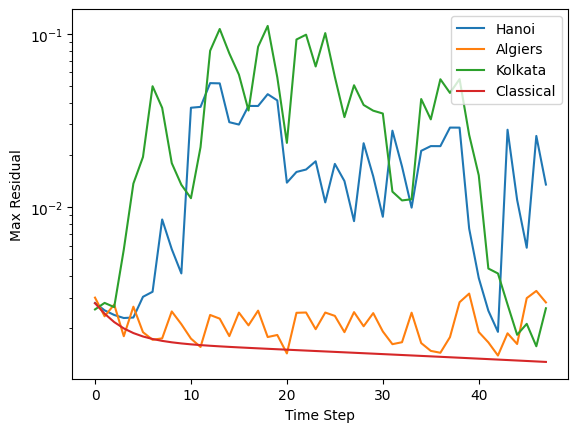

In [10]:
plt.plot([hanoi[i]['max_res'] for i in range(1,len(hanoi))], label='Hanoi')
plt.plot([alg4[i]['max_res'] for i in range(1,len(alg4))], label='Algiers')
plt.plot([kol[i]['max_res'] for i in range(1,len(kol))], label='Kolkata')
# for k in range(20,len(alg3),20):
#    plt.axvline(x=k,color='r',linestyle=':')
plt.plot([store_classical[i]['max_res'] for i in range(1,len(kol))],label='Classical')
plt.xlabel("Time Step")
plt.legend()
plt.yscale('log')
plt.ylabel("Max Residual")

Text(0, 0.5, 'Normalized Error')

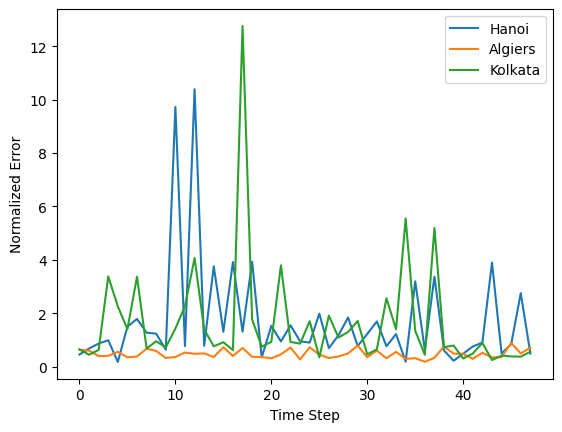

In [17]:
plt.plot([hanoi[i]['hw_error'] for i in range(1,len(hanoi))], label='Hanoi')
plt.plot([alg4[i]['hw_error'] for i in range(1,len(alg4))], label='Algiers')
plt.plot([kol[i]['hw_error'] for i in range(1,len(kol))], label='Kolkata')
# for k in range(20,len(alg3),20):
#    plt.axvline(x=k,color='r',linestyle=':')
plt.xlabel("Time Step")
plt.legend()
plt.ylabel("Normalized Error")

In [9]:
#sv_fid =[state_fidelity(store_classical[m]['p']/np.linalg.norm(store_classical[m]['p']),store_quantum_sv[m]['p'].real/np.linalg.norm(store_quantum_sv[m]['p'])) for m in range(1,50)]
alg_fid =[state_fidelity(store_classical[m]['p']/np.linalg.norm(store_classical[m]['p']),alg4[m]['p'].real/np.linalg.norm(alg4[m]['p'])) for m in range(1,len(alg4))]
hanoi_fid =[state_fidelity(store_classical[m]['p']/np.linalg.norm(store_classical[m]['p']),hanoi[m]['p'].real/np.linalg.norm(hanoi[m]['p'])) for m in range(1,len(hanoi))]
kol_fid =[state_fidelity(store_classical[m]['p']/np.linalg.norm(store_classical[m]['p']),kol[m]['p'].real/np.linalg.norm(kol[m]['p'])) for m in range(1,len(kol))]

Text(0, 0.5, 'Fidelity')

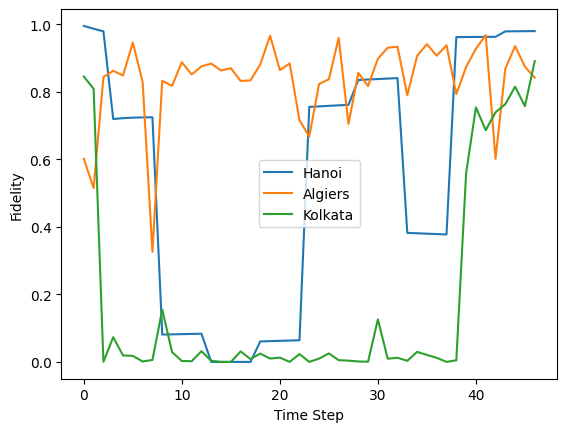

In [18]:
plt.plot([hanoi_fid[i] for i in range(1,len(hanoi_fid))],label='Hanoi')
plt.plot([alg_fid[i] for i in range(1,len(alg_fid))],label='Algiers')
plt.plot([kol_fid[i] for i in range(1,len(kol_fid))],label='Kolkata')

plt.xlabel("Time Step")
plt.legend()
plt.ylabel("Fidelity")

## Benchmark

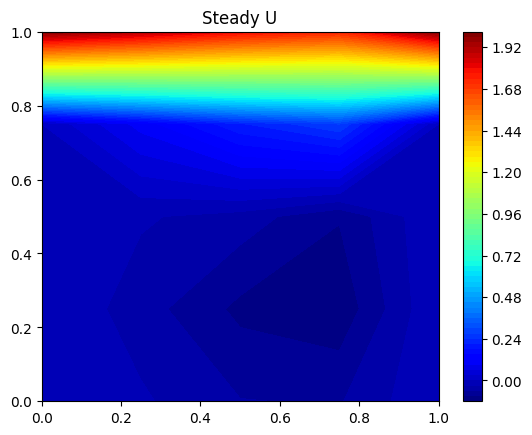

In [19]:
X, Y = np.meshgrid(x.toarray(), y.toarray())
plt.figure()
plt.contourf(X, Y, store_classical[4999]['u'].toarray().T, 80, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

In [12]:
GhiaU = np.loadtxt('./Benchmark/GhiaU.txt', skiprows=1)
GhiaV = np.loadtxt('./Benchmark/GhiaV.txt', skiprows=1)
y_Ghia = GhiaU[:, 0]
x_Ghia = GhiaV[:, 0]

In [13]:
# Understand what's inside the benchmark data
import pandas as pd
# pd.set_option('display.max_columns', None)
df = pd.read_table("./Benchmark/GhiaU.txt", skiprows=0, delimiter='\r')
print(df)

   # Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). 
0   # High-Re solutions for incompressible flow us...      
1   # Journal of computational physics, 48(3), 387...      
2                                                   #      
3                                           # TABLE I      
4   # Results for $u$-velocity along Vertical Line...      
5   #---------------------------------------------...      
6              #                                   Re      
7   #       --------------------------------------...      
8   #  y      100      400      1000     3200     ...      
9   #---------------------------------------------...      
10  1.0000  1.00000  1.00000  1.00000  1.00000  1....      
11  0.9766  0.84123  0.75837  0.65928  0.53236  0....      
12  0.9688  0.78871  0.68439  0.57492  0.48296  0....      
13  0.9609  0.73722  0.61756  0.51117  0.46547  0....      
14  0.9531  0.68717  0.55892  0.46604  0.46101  0....      
15  0.8516  0.23151  0.29093  0.33304  0

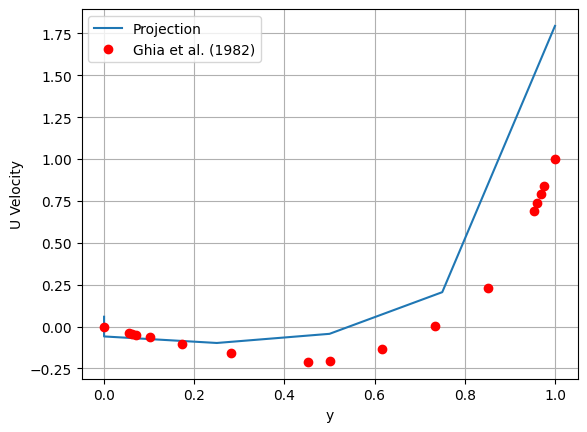

In [14]:
plt.plot(y.toarray(), u.toarray()[len(u.toarray())//2,:].T, label="Projection")
plt.plot(y_Ghia, GhiaU[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.legend()